In [1]:
%matplotlib inline

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import datetime as dt
import dateutil.parser

In [2]:
def convert(date):
    dt = dateutil.parser.parse(date).replace(tzinfo=None)
    epoch = dt.utcfromtimestamp(0)
    delta = dt - epoch
    return delta.total_seconds()

In [3]:
def speed_to_pace(speed):
    miuntes, seconds = divmod(100 / (6 * speed), 1)
    seconds *= 60
    return (miuntes, seconds)

In [4]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/APE_runs_oct26-mar22"
window_size_half = 3
colnames = np.array(['time', 'elevation', 'distance', 'speed', 'HR'])
Datasets_all = []
os.chdir(path)
for file in glob.glob("*.tab"):
    ds = np.genfromtxt(file, skip_header=1, delimiter='\t', converters={0: convert})
    ds[:,0] -= ds[0,0]                              # time reference set to 0
      
    if (ds[:,2].max() > 10000) == (ds[:,2].max() < 13000):
        ds = pd.DataFrame(ds,columns=colnames)
        slope = np.array([])
        pace = []

        for i in ds.index:
            index = np.arange(i - window_size_half + 1, i + window_size_half + 1)
            index = index[(index >= 0) & (index < len(ds))]
            dataset_part = ds[['distance','elevation']].iloc[index].dropna()

            regr = lm.LinearRegression()
            regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))

            slope = np.append(slope,regr.coef_)

        dataset_new = ds.drop(['elevation','HR'], axis=1)
        dataset_new['slope'] = slope

        Datasets_all.append(dataset_new)
len(Datasets_all)

7

In [5]:
def profile2D(data_in, res=25, pr=[25, 50, 75]):
    vx_counts, vx_edges = np.histogram(data_in[[0]],res)
    vx_factor = pd.cut(data_in.icol(0),res) 
    lower_intervals = np.array([])
    upper_intervals = np.array([])
    for i in range(len(vx_counts)):
        lower_intervals = np.append(lower_intervals, vx_edges[i])
        upper_intervals = np.append(upper_intervals, vx_edges[i+1])
    vx_intervals = np.array([lower_intervals, upper_intervals])
    vx_mids = vx_intervals.mean(0)
    data_split = data_in.icol(1).groupby(vx_factor).groups
    q = []
    for k,v in data_split.iteritems():
        q.append(np.percentile(data_in[[1]].loc[v],pr))
    quantiles1 = pd.DataFrame(q,index=[data_split.keys()],columns=[str(p)+'%' for p in pr])
    quantiles1.sort_index(inplace=True,ascending=False)
    quantiles2 = quantiles1.sort_index(ascending=True)
    quantiles = pd.concat([quantiles1[len(quantiles1)/2:], quantiles2[len(quantiles1)/2+1:]])
    return [quantiles, vx_mids, vx_intervals, vx_counts]

In [6]:
slope_min = -0.2                              #slope
slope_max = 0.2                               #slope
speed_min = 0                                #speed
speed_max = 5                                #speed
slope_resolution = 25
distance_step = 100
n_files = len(Datasets_all)
probabilities = np.arange(10, 91, 1)

In [7]:
training_data = pd.concat(Datasets_all,ignore_index=True)
subset_data = training_data.loc[:,['slope','speed']]
subset_data_filtered = subset_data[(subset_data.slope < slope_max)
                                   &(subset_data.slope > slope_min)
                                   &(subset_data.speed > speed_min)
                                   &(subset_data.speed < speed_max)]

current_profile = profile2D(subset_data_filtered,pr=[50])

In [8]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST"
os.chdir(path)
file = "Morat_Fribourg2014.tab"

dataset = np.genfromtxt(file, skip_header=1,delimiter='\t', converters={0: convert})
dataset[:,0] -= dataset[0,0]
dataset = pd.DataFrame(dataset,columns=colnames)
slope = np.array([])
for j in dataset.index:
    index = np.arange(j-window_size_half+1, j+window_size_half+1)
    index = index[(index >= 0) & (index < len(dataset))]
    dataset_part = dataset.iloc[index].dropna()
    regr = lm.LinearRegression()
    regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
    slope = np.append(slope,regr.coef_)

validation_data = pd.concat([dataset.dropna(), pd.DataFrame(slope,columns=['slope']).dropna()], axis=1)
validation_data.head()

,time,elevation,distance,speed,HR,slope
0,0,510.200012,0.000000,1.437,120,0.010038
1,1,510.399994,2.300000,0.774,121,-0.018887
2,5,511.000000,11.610000,2.193,124,-0.074994
3,20,510.600006,32.230000,1.176,124,-0.107911
4,31,509.200012,53.549999,1.260,123,-0.125611


In [15]:
prediction = np.array([])
for i in np.arange(0,len(current_profile[0].columns)):
    q = current_profile[0].T.iloc[i]    
    for sl in validation_data.slope:
        temp = q.loc[(current_profile[2][0] < sl) == (sl <= current_profile[2][1])]
        if len(temp) == 0:
            if sl <= current_profile[2][0][0]:
                a = q[0]
                prediction = np.append(prediction, a)
            elif sl > current_profile[2][1][len(current_profile[0])-1]:
                a = q[len(current_profile[0])-1]
                prediction = np.append(prediction,a)
        prediction = np.append(prediction,temp)

distances = np.array(validation_data.distance)
distance_diffs = np.concatenate([[distances[0]], distances[1:] - distances[:len(distances)-1]])

time_runner = np.array(validation_data.time)
time_diffs = np.concatenate([[time_runner[0]], time_runner[1:] - time_runner[:len(time_runner)-1]])
times_prediction = distance_diffs / prediction
times_prediction[0] = 0
times = np.arange(len(time_runner))
rt = np.vectorize(lambda x: times_prediction[x:].sum(axis=0))
t = np.vectorize(lambda x: times_prediction[:x+1].sum(axis=0))
times_estimated_total = np.concatenate([[0], time_runner[:-1]]) + times_prediction
remaining_time = rt(times)
total_time = time_runner + remaining_time
total_predicted = t(times)

print "{0} {1:.2f} km".format(file[:-4], validation_data.distance.iloc[-1]/1000)
print "Tiempo real de carrera {}".format(dt.timedelta(seconds=validation_data.time.iloc[-1]))
print "Tiempo predicho de carrera {} ".format(dt.timedelta(seconds=round(times_prediction.sum()))),
print 'Error: {0} ({1:0.2f}%)'.format(dt.timedelta(seconds=round(abs(validation_data.time.iloc[-1] - times_prediction.sum()))),
                                   abs((validation_data.time.iloc[-1] - times_prediction.sum())/validation_data.time.iloc[-1] * 100))

Morat_Fribourg2014 17.18 km
Tiempo real de carrera 1:32:14
Tiempo predicho de carrera 1:30:36  Error: 0:01:38 (1.77%)


In [16]:
if file == 'test_activity.tab':
    test = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    test.to_pickle('cs4_test')
    print file
    print test.head()

elif file == 'feeling_bad_activity.tab':
    feelingBad = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    feelingBad.to_pickle('cs4_feelingBad')
    print file
    print feelingBad.head()

elif file == 'Morat_Fribourg2014.tab':
    moratFribourg = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    moratFribourg.to_pickle('cs4_morFrib')
    print file
    print moratFribourg.head()

Morat_Fribourg2014.tab
   $\Delta{}d$  $\Delta{}t^{est}$  $\Delta{}t^{real}$   Distance   Elevation  \
0         0.00           0.000000                   0   0.000000  510.200012   
1         2.30           0.716511                   1   2.300000  510.399994   
2         9.31           2.850582                   4  11.610000  511.000000   
3        20.62           6.387856                  15  32.230000  510.600006   
4        21.32           6.528862                  11  53.549999  509.200012   

   Remaining Time  Slope (%)  Speed  Time Runner  Time estimated  \
0     5436.053297   1.003826  1.437            0        0.000000   
1     5436.053297  -1.888679  0.774            1        0.716511   
2     5435.336786  -7.499390  2.193            5        3.850582   
3     5432.486205 -10.791096  1.176           20       11.387856   
4     5426.098348 -12.561123  1.260           31       26.528862   

   Total predicted   Total time  
0         0.000000  5436.053297  
1         0.716511 

In [2]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST"
os.chdir(path)

test = pd.read_pickle('cs4_test')
feelingBad = pd.read_pickle('cs4_feelingBad')
moratFribourg = pd.read_pickle('cs4_morFrib')

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

def add_inner_title(ax, title, loc, size=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    if size is None:
        size = dict(size=plt.rcParams['legend.fontsize'])
    at = AnchoredText(title, loc=loc, prop=size,
                      pad=0., borderpad=0.5,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at

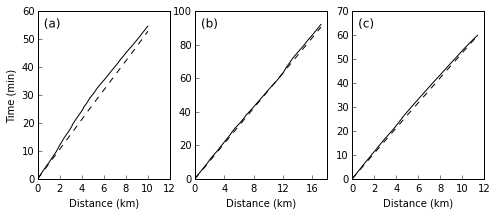

In [4]:
# REAL TIME VS PREDICTED TIME
fig = plt.figure(figsize=(8,3), dpi=72)
ax1 = fig.add_subplot(111)
divider = make_axes_locatable(ax1)
ax2 = divider.new_horizontal(size="100%", pad=0.35)
ax3 = divider.new_horizontal(size="100%", pad=0.35)

fig1 = ax1.get_figure()
fig1.add_axes(ax2)
fig1.add_axes(ax3)

ax1.plot(feelingBad['Distance']/1000, feelingBad['Time Runner']/60, 'k', label='Race time')
ax1.plot(feelingBad['Distance']/1000, feelingBad['Total predicted']/60, 'k--', label='Predicted time')
ax2.plot(moratFribourg['Distance']/1000, moratFribourg['Time Runner']/60, 'k', label='Race time')
ax2.plot(moratFribourg['Distance']/1000, moratFribourg['Total predicted']/60, 'k--', label='Predicted time')
ax3.plot(test['Distance']/1000, test['Time Runner']/60, 'k', label='Race time')
ax3.plot(test['Distance']/1000, test['Total predicted']/60, 'k--', label='Predicted time')
ax1.set_ylabel('Time (min)')

#fig.legend(loc='best')
for ax, im_title in zip([ax1, ax2, ax3], ["(a)", "(b)", "(c)"]):
        t = add_inner_title(ax, im_title, loc=2)
        t.patch.set_ec("none")
        t.patch.set_alpha(0.5)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel('Distance (km)')
ax2.set_xticks(ax2.get_xticks()[::2])   
plt.draw()
plt.show()
fig.savefig('../../../Thesis/images/TimeRunnerVsTimePredictedCS4.pdf',bbox_inches='tight', dpi=fig.dpi)

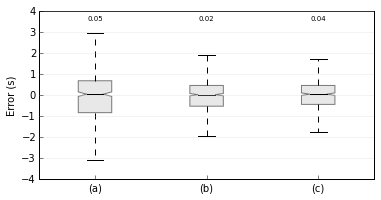

In [11]:
# BOXPLOTS ERRORES DE PREDICCIÓN
errorFeelingBad = feelingBad['$\Delta{}t^{est}$'] - feelingBad['$\Delta{}t^{real}$']
errorMoratFrib = moratFribourg['$\Delta{}t^{est}$'] - moratFribourg['$\Delta{}t^{real}$'] 
errorTest = test['$\Delta{}t^{est}$'] - test['$\Delta{}t^{real}$']
errors = [errorFeelingBad, errorMoratFrib, errorTest]
numBoxes = len(errors)
pos = np.arange(numBoxes)+1

fig = plt.figure(figsize=(6,3), dpi=72)
ax = fig.add_subplot(111)
bp = ax.boxplot(errors, labels=['(a)', '(b)', '(c)'], patch_artist=True, sym='', notch=True)

plt.setp(bp['boxes'], color='black', facecolor = 'lightgrey', alpha=0.5)
plt.setp(bp['medians'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['caps'], color='black')
ax.set_ylim([-4, 4])
top = ax.get_ylim()[1]*0.89
medians = [np.nanmedian(i) for i in errors]
upperLabels = [str(np.round(s, 2)) for s in medians]

for tick,label in zip(range(numBoxes),ax.get_xticklabels()):
    ax.text(pos[tick], top, upperLabels[tick], horizontalalignment='center', size='x-small', color='black')

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('Error (s)')
fig.savefig('../../../Thesis/images/bxplotErrorsCS4.pdf',bbox_inches='tight', dpi=fig.dpi)

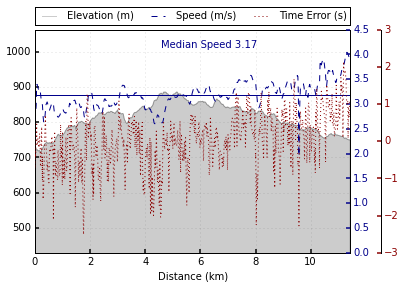

In [55]:
# GRAFICA DEL ERROR DE PREDICCION CON ELEVACION Y VELOCIDAD
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.itervalues():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize=(7,4), dpi=72)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(test['Distance'], test['Elevation'], color='k', label='Elevation (m)',alpha=0.2)
host.fill_between(test['Distance'], 0, test['Elevation'], color='k', alpha=0.2)
p2, = par1.plot(test['Distance'], test['Speed'], color='DarkBlue', linestyle='--', label='Speed (m/s)')
p2.axes.axhline(y=training_data.speed.median(), color='DarkBlue')
p3, = par2.plot(test['Distance'], test['$\Delta{}t^{est}$'] - test['$\Delta{}t^{real}$'], 
                color='DarkRed', linestyle=':', label=r'Time Error (s)')

host.set_xlim([test['Distance'].min(), test['Distance'].max()])
host.set_xticklabels([np.str(int(i)) for i in host.get_xticks()/1000])
host.set_ylim([test['Elevation'].min()*0.8, test['Elevation'].max()*1.1])

host.set_xlabel(r'Distance (km)')

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
host.get_xaxis().tick_bottom()
host.legend((p1, p2, p3),(p1.get_label(), p2.get_label(), p3.get_label()),
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.,
            fontsize=10)
host.grid(alpha=0.25)
host.text(0.4*host.get_xlim()[-1],0.95*host.get_ylim()[-1],
          'Median Speed {:.2f}'.format(training_data.speed.median()), color='DarkBlue', fontsize=10)
fig.savefig("../../../Thesis/images/errorCS4Test.pdf", bbox_inches='tight', dpi=fig.dpi)